In [482]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import random
import pickle
import itertools

In [50]:
%cd /home/dongjoolee/Spatial

/home/dongjoolee/Spatial


In [51]:
adda = sc.read_h5ad('smaller_dada.h5ad')

In [29]:
gene_names = adda.var.index.tolist()
row_col = adda.obs[['array_row', 'array_col']].values.astype(int)
df = pd.DataFrame(data=np.concatenate((row_col, adda.X), axis=1), columns=['row', 'col'] + gene_names)
df['row'] = df['row'].astype(int)
df['col'] = df['col'].astype(int)

RESIZE_WIDTH = 128
RESIZE_HEIGHT = 64

def resize_gene_maps(gene_map):
    img = Image.fromarray(np.uint8(gene_map * 255) , 'L')
    img = img.resize((RESIZE_WIDTH, RESIZE_HEIGHT))
    img = np.asarray(img) / 255
    return img

def min_max_scale(gm):
    not_nan_values = gm[~np.isnan(gm)]
    mx = not_nan_values.max()
    mn = not_nan_values.min()
    gm = gm - mn
    gm = gm / (mx - mn)
    return gm

def make_gene_map(gene_df, gene_name):
    gm = min_max_scale(gene_df.pivot('row', 'col', gene_name).values)
    gm[np.isnan(gm)] = 0
    gm = gm[1:-1]
    gm = np.concatenate((np.zeros([RESIZE_HEIGHT, RESIZE_WIDTH - gm.shape[1]]), gm), axis=1)
    return gm

# row_len = row_col[:, 0].max() - row_col[:, 0].min() + 1
# col_len = row_col[:, 1].max() - row_col[:, 1].min() + 1

gene_maps = np.zeros([len(gene_names), RESIZE_HEIGHT, RESIZE_WIDTH], dtype=np.float32)

for i, name in enumerate(gene_names):
    gene_maps[i] = make_gene_map(df, name)

# Functions

In [214]:
cast = gene_maps[0].shape

In [178]:
summation = np.zeros(cast)
for i in range(gene_maps.shape[0]):
    summation += gene_maps[i]

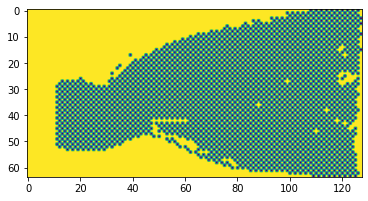

In [182]:
plt.imshow(summation == 0)

In [251]:
AVAILABLE_CENTER = [[i,j] for i, j in zip(np.where(summation != 0)[0], np.where(summation != 0)[1])]

In [216]:
# To use probes available in training data only
def possible_probes_filter(canvas):
    for i, j in zip(np.where(summation == 0)[0], np.where(summation == 0)[1]):
        canvas[i, j] = 0
    return(canvas)

In [217]:
def makeGaussian2(x_center=0, y_center=0, theta=0, sigma_x=10, sigma_y=10, x_size=cast[1], y_size=cast[0]):
    # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
    # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
    # x_size and y_size give the size of the frame 
    theta = 2*np.pi*theta/360
    x = np.arange(0,x_size, 1, float)
    y = np.arange(0,y_size, 1, float)
    y = y[:,np.newaxis]
    sx = sigma_x
    sy = sigma_y
    x0 = x_center
    y0 = y_center

    # rotation
    a=np.cos(theta)*x - np.sin(theta)*y
    b=np.sin(theta)*x + np.cos(theta)*y
    a0=np.cos(theta)*x0 - np.sin(theta)*y0
    b0=np.sin(theta)*x0 + np.cos(theta)*y0
    return np.exp(-(((a-a0)**2)/(2*(sx**2)) + ((b-b0)**2) /(2*(sy**2))))

# 1. Translation Invariant

In [431]:
def get_tl_invariant(n_total, n_common, radius_x = 6, radius_y = 6, noise = True):
    # returns list of 2 simulation patten images
    # n_total : The number of patches in image
    # n_common : The number of patches with same position in both images
    # radius_x, radius_y : set radius of patches
    # noise : whether to add gaussian noise
    
    assert n_total >= n_common
    
    simdata = [np.zeros(cast), np.zeros(cast)]
    
    for epoch in range(n_total):
        if(n_common > epoch):
            center_y, center_x = random.sample(AVAILABLE_CENTER, 1)[0]
            Gaussian_circle = makeGaussian2(center_x, center_y, 0, radius_x, radius_y, cast[1], cast[0])
            simdata[0] += Gaussian_circle
            simdata[1] += Gaussian_circle 
        
        else:
          for i in range(2):
                center_y, center_x = random.sample(AVAILABLE_CENTER, 1)[0]
                Gaussian_circle = makeGaussian2(center_x, center_y, 0, radius_x, radius_y, cast[1], cast[0])
                simdata[i] += Gaussian_circle
    if noise:
        simdata[0] += np.random.normal(0, .05, cast)
        simdata[1] += np.random.normal(0, .05, cast)
    
    simdata[0] = np.clip(simdata[0], 0, 1)
    simdata[1] = np.clip(simdata[1], 0, 1)
    
    simdata[0] = possible_probes_filter(simdata[0])
    simdata[1] = possible_probes_filter(simdata[1])
    return(simdata)

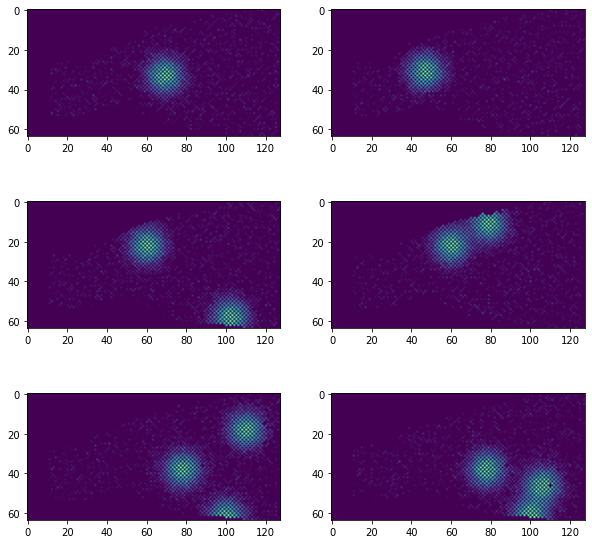

In [432]:
tl1 = get_tl_invariant(n_total = 1, n_common = 0)
tl2 = get_tl_invariant(n_total = 2, n_common = 1)
tl3 = get_tl_invariant(n_total = 3, n_common = 2)

fig, axes = plt.subplots(3,2, figsize = (10,10))
axes[0,0].imshow(tl1[0], vmin = 0, vmax = 1)
axes[0,1].imshow(tl1[1], vmin = 0, vmax = 1)
axes[1,0].imshow(tl2[0], vmin = 0, vmax = 1)
axes[1,1].imshow(tl2[1], vmin = 0, vmax = 1)
axes[2,0].imshow(tl3[0], vmin = 0, vmax = 1)
axes[2,1].imshow(tl3[1], vmin = 0, vmax = 1)
plt.show()

# 2. Transformation invariant

In [433]:
def get_tf_invariant(n_total, n_common, radius_list = list(range(3, 12, 1)), random_rotate = False, noise = True):
    # returns list of 2 simulation patten images
    # n_total : The number of patches in image
    # n_common : The number of patches with same size in both images
    # radius_list : pool of random radius
    # random_rotate: whether to rotate patches randomly
    # noise : whether to add gaussian noise
    assert n_total >= n_common
    
    simdata = [np.zeros(cast), np.zeros(cast)]
    
    for epoch in range(n_total):
        if(n_common > epoch):
            center_y, center_x = random.sample(AVAILABLE_CENTER, 1)[0]
            radius_x = random.sample(radius_list, 1)[0]
            radius_y = random.sample(radius_list, 1)[0]
            
            if random_rotate: 
                theta = np.radians(random.sample(list(range(360)),1)[0])
            else: theta = 0
            
            Gaussian_circle = makeGaussian2(center_x, center_y, theta, radius_x, radius_y, cast[1], cast[0])
            simdata[0] += Gaussian_circle
            simdata[1] += Gaussian_circle 
        
        else:
          center_y, center_x = random.sample(AVAILABLE_CENTER, 1)[0]  
          for i in range(2):
                radius_x = random.sample(radius_list, 1)[0]
                radius_y = random.sample(radius_list, 1)[0]
                if random_rotate: 
                    theta = np.radians(random.sample(list(range(360)),1)[0])
                else: theta = 0
                
                Gaussian_circle = makeGaussian2(center_x, center_y, theta, radius_x, radius_y, cast[1], cast[0])
                simdata[i] += Gaussian_circle
    if noise:
        simdata[0] += np.random.normal(0, .05, cast)
        simdata[1] += np.random.normal(0, .05, cast)
    
    simdata[0] = np.clip(simdata[0], 0, 1)
    simdata[1] = np.clip(simdata[1], 0, 1)
    
    simdata[0] = possible_probes_filter(simdata[0])
    simdata[1] = possible_probes_filter(simdata[1])
    return(simdata)

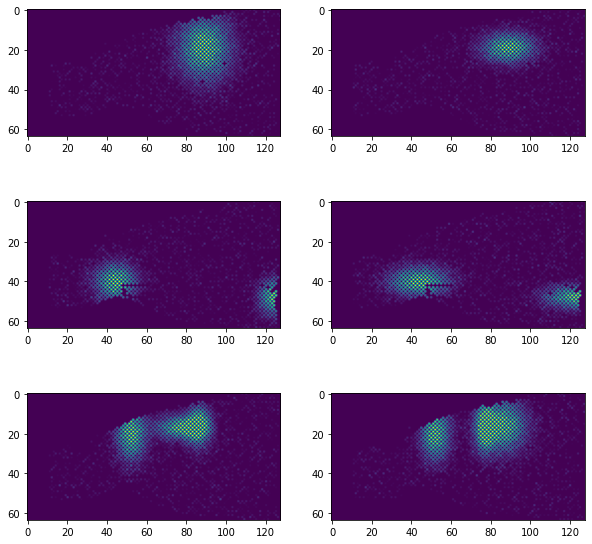

In [434]:
tf1 = get_tf_invariant(n_total = 1, n_common = 0)
tf2 = get_tf_invariant(n_total = 2, n_common = 0)
tf3 = get_tf_invariant(n_total = 3, n_common = 1)

fig, axes = plt.subplots(3,2, figsize = (10,10))
axes[0,0].imshow(tf1[0], vmin = 0, vmax = 1)
axes[0,1].imshow(tf1[1], vmin = 0, vmax = 1)
axes[1,0].imshow(tf2[0], vmin = 0, vmax = 1)
axes[1,1].imshow(tf2[1], vmin = 0, vmax = 1)
axes[2,0].imshow(tf3[0], vmin = 0, vmax = 1)
axes[2,1].imshow(tf3[1], vmin = 0, vmax = 1)
plt.show()

# 3. Contour pattern

In [587]:
def get_contour(n_total, radius_list = list(range(3, 8, 1)), noise = True):
    # returns list of 2 simulation patten images
    # n_total : The number of patches in image
    # noise : whether to add gaussian noise
    
    simdata = [np.full(cast, 0.5), np.full(cast, 0.5)]
    
    for epoch in range(n_total):
        center_y, center_x = random.sample(AVAILABLE_CENTER, 1)[0]
        radius_x = random.sample(radius_list, 1)[0]
        radius_y = random.sample(radius_list, 1)[0]
            
        Gaussian1 = makeGaussian2(center_x, center_y, 0, radius_x*0.5, radius_y*0.5, cast[1], cast[0])/6
        Gaussian2 = makeGaussian2(center_x, center_y, 0, radius_x, radius_y, cast[1], cast[0])/6
        Gaussian3 = makeGaussian2(center_x, center_y, 0, radius_x*2, radius_y*2, cast[1], cast[0])/6
        Gaussian4 = makeGaussian2(center_x, center_y, 0, radius_x*4, radius_y*4, cast[1], cast[0])/6
        Gaussian = Gaussian1 + Gaussian2 + Gaussian3 + Gaussian4
        
        randomint = random.randint(0,100)
        
        simdata[randomint % 2] += Gaussian
        simdata[(randomint + 1) % 2] -= Gaussian

    if noise:
        simdata[0] += np.random.normal(0, .05, cast)
        simdata[1] += np.random.normal(0, .05, cast)
    
    simdata[0] = np.clip(simdata[0], 0, 1)
    simdata[1] = np.clip(simdata[1], 0, 1)
    
    simdata[0] = possible_probes_filter(simdata[0])
    simdata[1] = possible_probes_filter(simdata[1])
    return(simdata)

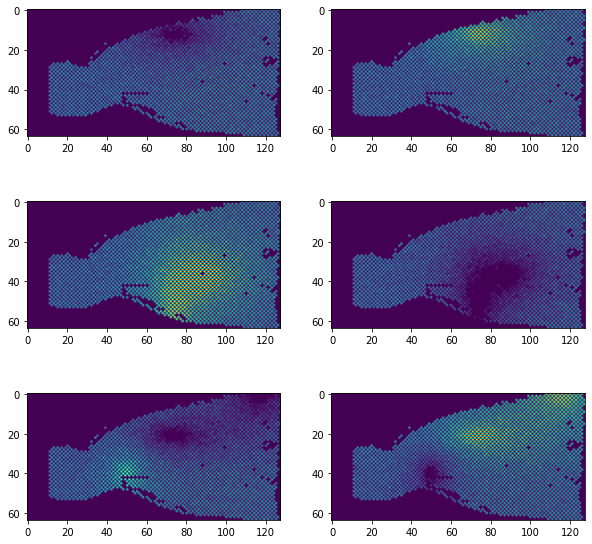

In [588]:
co1 = get_contour(n_total = 1)
co2 = get_contour(n_total = 2)
co3 = get_contour(n_total = 3)

fig, axes = plt.subplots(3,2, figsize = (10,10))
axes[0,0].imshow(co1[0], vmin = 0, vmax = 1)
axes[0,1].imshow(co1[1], vmin = 0, vmax = 1)
axes[1,0].imshow(co2[0], vmin = 0, vmax = 1)
axes[1,1].imshow(co2[1], vmin = 0, vmax = 1)
axes[2,0].imshow(co3[0], vmin = 0, vmax = 1)
axes[2,1].imshow(co3[1], vmin = 0, vmax = 1)

# Export simulation data

In [529]:
# 1. Translation invariant set
tl_invariant_set = []
for n_total, n_common in np.repeat([[1,0], [2,0], [2,1], [3,0], [3,1], [3,2], [4,0], [4,1], [4,2], [4,3]], 10, axis=0):
    tl_invariant_set.append(get_tl_invariant(n_total, n_common))
tl_invariant_set = np.array(tl_invariant_set)

In [533]:
# 2. Transformation invariant set
tf_invariant_set = []
for n_total, n_common in np.repeat([[1,0], [2,0], [2,1], [3,0], [3,1], [3,2], [4,0], [4,1], [4,2], [4,3]], 10, axis=0):
    tf_invariant_set.append(get_tf_invariant(n_total, n_common))
tf_invariant_set = np.array(tf_invariant_set)

In [589]:
# 3. Contour pattern set
contour_set = []
for n_total in np.repeat([1, 2, 3, 4], 25):
    contour_set.append(get_contour(n_total))
contour_set = np.array(contour_set)

In [596]:
with open('./pickle/tl_invariant_set.pickle', 'wb') as f:
    pickle.dump(tl_invariant_set, f)
with open('./pickle/tf_invariant_set.pickle', 'wb') as f:
    pickle.dump(tf_invariant_set, f)
with open('./pickle/contour_set.pickle', 'wb') as f:
    pickle.dump(contour_set, f)

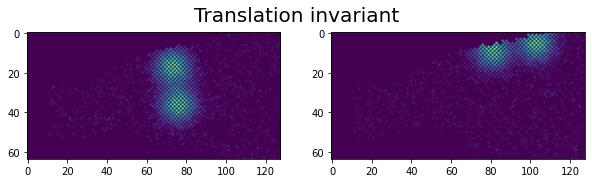

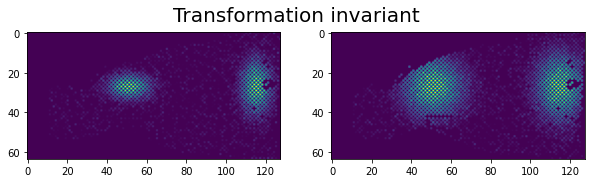

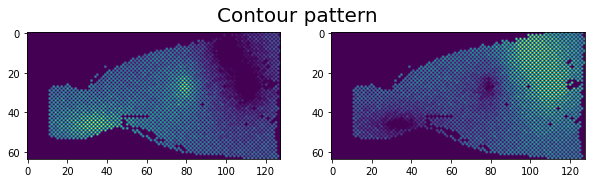

In [592]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Translation invariant', fontsize=20, y=0.75)
axes[0].imshow(tl_invariant_set[15][0])
axes[1].imshow(tl_invariant_set[15][1])

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.suptitle('Transformation invariant',  fontsize=20, y=0.75)
axes1[0].imshow(tf_invariant_set[15][0])
axes1[1].imshow(tf_invariant_set[15][1])

fig2, axes2 = plt.subplots(1, 2, figsize=(10,5))
fig2.suptitle('Contour pattern',  fontsize=20, y=0.75)
axes2[0].imshow(contour_set[75][0])
axes2[1].imshow(contour_set[75][1])

plt.show()